#  Задача: Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — её уже сделали за нас.

Нужно построить модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75.

## 1. Откройте и изучите файл

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("./users_behavior.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Проверим на наличие мультиколлинеарности. 

<AxesSubplot:xlabel='calls', ylabel='minutes'>

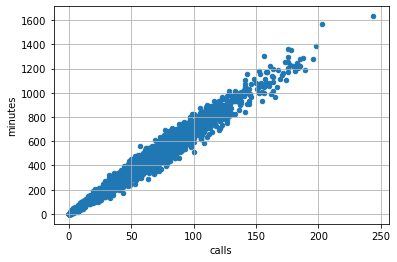

In [5]:
df.plot(x='calls', y='minutes', kind='scatter', grid=True)

In [6]:
df['calls'].corr(df['minutes'])

0.9820832355742292

In [7]:
df = df.drop(['calls'], axis=1)

**Вывод**

Все даннные были заранее обработаны и не требуются в обработке. Сразу можно заметить целевой признак в колонке *is_ultra*. Дальнейшее обучение моделей по по данным поможет нам предсказывать по поведению клиента какой ему нужен тариф. Также были выявлены два столбца `calls` и `minutes`, которые по логике должны быть зависимы, что собственно и оказалось, с большим значением корреляции. В следствие этого я убрал колонку `calls`, чтобы не перегружать будущие модели.


## 2. Разбиваем данные на выборки

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
df_train, df_test_pre = train_test_split(df, test_size=0.4, random_state=12345)

In [10]:
df_test, df_valid = train_test_split(df_test_pre, test_size=0.5, random_state=12345)

In [11]:
print(df_test.shape, df_valid.shape, df_train.shape)

(643, 4) (643, 4) (1928, 4)


**Вывод** 

Все данные разделил в соотношение 3:1:1 для обучающей,валидационной,тестовой выборок. В итоге получил нужного размера выборки для дальнейшего анализа. Результаты разделения проверил методом `.shape`. 

## 3. Исследование моделей

Здесь я буду исследовать 3 различные модели: DecicsionTreeClassifier, RandomForestClassifier, LogisticRegression. По результатам оценки качетсва моделей на валидационной выборке, можно будет судить о лидере среди этих моделей.

**1-я модель**

Здесь я использую модель DecicsionTreeClassifier, меняя гиперпараметры глубины решающего дерева. Также я создаю директорию где оставляю лучшие модели по результатам исследования на валидационной выборке 

In [12]:
from tempfile import mkdtemp
import joblib
save_dir = mkdtemp()
import os 
filename_decision_tree = os.path.join(save_dir, 'model.joblib.decision_tree')

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

In [14]:
best_res = 0
best_model = None
for i in range(1,10):
    model = DecisionTreeClassifier(random_state = 12345,max_depth=i)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    res = accuracy_score(target_valid, predictions)
    print('max_depth = {} :'.format(i), res)
    if res > best_res:
        best_res = res
        best_model = model


max_depth = 1 : 0.7356143079315708
max_depth = 2 : 0.7744945567651633
max_depth = 3 : 0.7791601866251944
max_depth = 4 : 0.7807153965785381
max_depth = 5 : 0.7884914463452566
max_depth = 6 : 0.776049766718507
max_depth = 7 : 0.7962674961119751
max_depth = 8 : 0.7807153965785381
max_depth = 9 : 0.7838258164852255


In [15]:
joblib.dump(best_model, filename_decision_tree)

['/var/folders/zh/zsymzr9j78n9pp328rf9k0b80000gn/T/tmp3f8puwwb/model.joblib.decision_tree']

**Комментарий** 

Лучшая модель по резульатам тестирования оказалась глубина дерева со значением max_depth=8, accuracy=0.7456310679611651.

**2-я модель**

Здесь используется модель RandomForestClassifier, меняя параметр кол-ва деревьев.

In [16]:
best_model = None
best_result = 0
for est in range(1, 11):
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    model.fit(features_train, target_train) 
    result = model.score(features_valid,target_valid) 
    print('number_estimator = {} :'.format(est), result)
    if result > best_result:
        best_model = model 
        best_result = result

number_estimator = 1 : 0.7107309486780715
number_estimator = 2 : 0.7589424572317263
number_estimator = 3 : 0.7713841368584758
number_estimator = 4 : 0.776049766718507
number_estimator = 5 : 0.7776049766718507
number_estimator = 6 : 0.7838258164852255
number_estimator = 7 : 0.7729393468118196
number_estimator = 8 : 0.7822706065318819
number_estimator = 9 : 0.7807153965785381
number_estimator = 10 : 0.7869362363919129


In [17]:
filename_random_forest = os.path.join(save_dir, 'model.joblib.random_forest')
joblib.dump(best_model, filename_random_forest)

['/var/folders/zh/zsymzr9j78n9pp328rf9k0b80000gn/T/tmp3f8puwwb/model.joblib.random_forest']

In [18]:
joblib.load(filename_random_forest)

RandomForestClassifier(n_estimators=10, random_state=12345)

**Комментарий** 

Лучшая модель по резульатам тестирования оказалась модель со значением n_estimators=10 и accuracy=0.7650485436893204.

**3-я модель**

In [19]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=12345)
model.fit(features_train,target_train) 
result = model.score(features_valid, target_valid) 
print(result)

0.6982892690513219


In [20]:
filename_logic_reg = os.path.join(save_dir, 'model.joblib.logistic')
joblib.dump(model, filename_logic_reg)

['/var/folders/zh/zsymzr9j78n9pp328rf9k0b80000gn/T/tmp3f8puwwb/model.joblib.logistic']

**Комментарий** 

Здесь в отличие не менялись гиперпараметры. Значение accuracy в данном случае 0.7107.

**Вывод**

По результатам тестирования разных видов моделей, лучше всего себя показали модели DecicsionTreeClassifier, RandomForestClassifier, со значениями max_depth=8 и n_estimators=10 соотв. Проверим дальше наши модели на тестовых данных

## 4. Проверка модели на тестовой выборке

In [21]:
feature_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

In [22]:
joblib.load(filename_decision_tree).score(feature_test, target_test)

0.7713841368584758

In [23]:
joblib.load(filename_random_forest).score(feature_test, target_test)

0.7589424572317263

In [24]:
joblib.load(filename_logic_reg).score(feature_test, target_test)

0.7076205287713841

**Вывод**

По результатам тестирования разных видов моделей, на тестовых данных, лучше всего себя показали модели DecicsionTreeClassifier, RandomForestClassifier, как и при исследование на валидационных данных. Доля правильных ответов больше 0.75, что удовлетворяет условия поставленной задачи.

## 5. Проверьте модели на адекватность

In [25]:
df['is_ultra'].value_counts() / df.shape[0]

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

In [26]:
df.drop(['is_ultra'], axis=1)

,minutes,messages,mb_used
0,311.90,83.0,19915.42
1,516.75,56.0,22696.96
2,467.66,86.0,21060.45
3,745.53,81.0,8437.39
4,418.74,1.0,14502.75
...,...,...,...
3209,910.98,20.0,35124.90
3210,190.36,0.0,3275.61
3211,634.44,70.0,13974.06
3212,462.32,90.0,31239.78


In [27]:
joblib.load(filename_random_forest).score(df.drop(['is_ultra'], axis=1), df['is_ultra'])

0.8985687616677038

In [28]:
from sklearn.dummy import DummyClassifier
strategies = ['most_frequent']
dummy_results = []
for strategy in strategies:
    dc = DummyClassifier(strategy = strategy, random_state = 42)
    dc.fit(features_train, target_train)
    result = dc.score(feature_test, target_test)
    dummy_results.append({strategy: result})

pd.DataFrame(dummy_results)

,most_frequent
0,0.706065
